### Introduction IN3063 Task 2

In this notebook we will be using a LSTM neural network created with Pytorch to try and predict stock prices (time series dataset). This involves the following steps:

1. Getting the data
2. Normalizing the data
3. Creating train/test validation splits
4. Defining our model
5. Training our model
6. Evaluating our model's performance
7. Hyperparameter optimization 

All the resources used to create this notebook can be found in the resources.txt file.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(42)

#### Getting the data

We will be trying to use the historical closing price and historical volume to predict tomorrow's closing price (this is what one would need to know in order to make profit trading stocks).

We will try to predict the stock price of Intel (INTC) looking at 3 years worth of data (2020-2023). To fill in any nulls in our dataset we will just use the last valid data point we have (pandas.DataFrame.ffill).

In [2]:
stock = "INTC"

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

stock_data = yf.download(stock, start, end)[["Close", "Volume"]]
stock_data = stock_data.ffill()
stock_data.astype("double")
stock_data.head(3)

[*********************100%%**********************]  1 of 1 completed


,Close,Volume
Date,,
2021-01-06,51.099998,36809600
2021-01-07,52.189999,32092300
2021-01-08,51.650002,34625400


#### Normalizing the data

Many ML models perform better when the data is scaled [3] and so we will be using a MinMaxScaler from sklearn to bring all of our data into a range between -1 to 1 while still keeping their relative differences (proportions to one another).

In [3]:
scaler = MinMaxScaler(feature_range=(-1, 1))
stock_data['Close'] = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))
stock_data['Volume'] = scaler.fit_transform(stock_data['Volume'].values.reshape(-1,1))

#### Creating train/test validation split:
As we are working with a time series dataset and out objective is to use historical data to predict tomorrows price we have to change our dataset into a format where 'X = the historical data' and 'Y = tomorrows price'.

What this means for our specific dataset is that we have to decide on a time window (number of days of historical data used to predict tomorrows price) say 45 and group our individual observations into that range. So for instance a single entry in our X would be a list of the closing price and volume over the last 45 days and a single entry of our Y would be tomorrow's price. We will splice our numpy arrays accordingly to achieve this [4]. 

In [4]:
num_days = 45
train_size = 0.8

stock_data_raw = stock_data.values
data_acm = []

for i in range(len(stock_data_raw) - num_days):
    data_acm.append(stock_data_raw[i: i + num_days])

data_acm = np.array(data_acm)

train = data_acm[:round(train_size*data_acm.shape[0])]
test = data_acm[train.shape[0]:]

x_train = train[::,:-1,:]
y_train = train[::,-1,:1]

x_test = test[::,:-1,:]
y_test = test[::,-1,:1]

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (568, 44, 2)
y_train.shape =  (568, 1)
x_test.shape =  (142, 44, 2)
y_test.shape =  (142, 1)


As we can see x_train contains 557 entries each once containg 60 days worth of data where each day contains 2 values ('closing price' and 'volume')

We can convert our numpy arrays into Tensors [5], this will allow our computations to execute on a GPU (if set up) GPUs are often more efficient for simple arithmetic computations such as the ones used for training a model.

In [5]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

#### Defining our model

LSTM (Long Short Term Memory) are similar to RNNs in that they re-feed previously seen inputs into the neuron, however, LSTMs use gates to better control the data held in the cells for predictions down the line. For our case this could be usefull as LSTMs can both learn from patterns they are exposed to and withold recently seen information [6].

We will create an LSTM using Pytorch. For our model architecture we will begin with a simple LSTM layer with an input size of 2 (closing price and volume) feeding into a Linear layer factoring in all the LSTM layer's outputs and spitting out a single predicted price.

For our loss function we will use RMSE and our optimization algorithm will be Adam (similar to gradient descent with a dynamic learning rate) [11].

In [6]:
hidden_size = 32
num_layers = 2 

class LSTM(nn.Module):
    def __init__(self, hidden_size, num_layers):
        self.hidden_size = hidden_size
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.lstm = nn.LSTM(2, hidden_size, num_layers, batch_first=True)
        self.out = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.out(x[:, -1, :])
        return x

model = LSTM(hidden_size, num_layers)

loss_foo = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


#### Training our model

We will now train our model, keeping track of how our loss changes through iterations (epochs).

In [7]:
epochs = 90
losses = []

for i in range(epochs):
    y_train_pred = model(x_train)

    loss = loss_foo(y_train_pred, y_train)
    losses.append(loss.item())

    if i % 10 == 0:
        print(f"Epoch = {i} and RMSE = {loss}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch = 0 and RMSE = 0.35452425479888916
Epoch = 10 and RMSE = 0.031075164675712585
Epoch = 20 and RMSE = 0.023398321121931076
Epoch = 30 and RMSE = 0.014184531755745411
Epoch = 40 and RMSE = 0.008792629465460777
Epoch = 50 and RMSE = 0.0058529251255095005
Epoch = 60 and RMSE = 0.004939358215779066
Epoch = 70 and RMSE = 0.004157898481935263
Epoch = 80 and RMSE = 0.003954986110329628


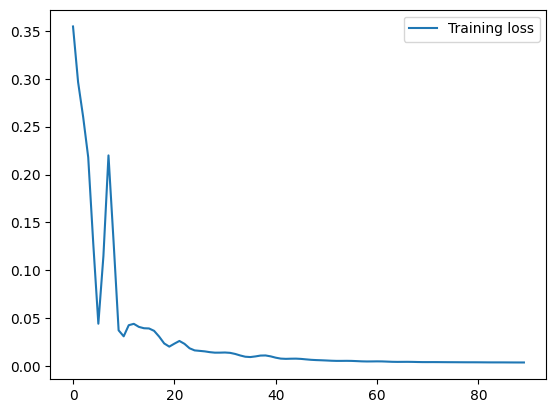

In [8]:
plt.plot(range(epochs), losses, label="Training loss")
plt.legend()
plt.show()

#### Evaluating model's performance

Now that our model has been trained we can use our testing dataset to evaluate it's performance. However, since we initially scalled (normalized) our values we now need to perform the inverse transformation in order to get the real stock price (which thankfully isn't limited to a number between -1 and 1 😊)

In [9]:
y_test_pred = model(x_test)

_y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
_y_test = scaler.inverse_transform(y_test.detach().numpy())

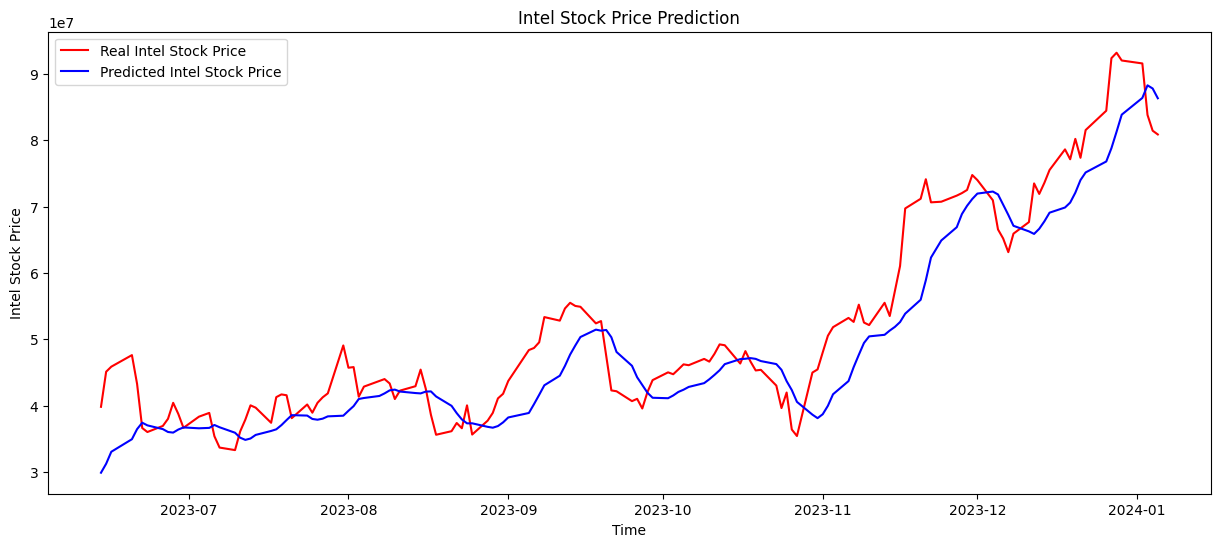

In [10]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(stock_data[len(stock_data)-len(_y_test):].index, _y_test, color = 'red', label = 'Real Intel Stock Price')
axes.plot(stock_data[len(stock_data)-len(_y_test):].index, _y_test_pred, color = 'blue', label = 'Predicted Intel Stock Price')
plt.title('Intel Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Intel Stock Price')
plt.legend()
plt.show()

Not bad for a first round now let's try and "functionize" our model design and training to play around with the hyperparameters and improve our performance.

In [11]:
print(f"Currently our RMSE is: {losses[-1]} let's see how much we can improve this by.")

Currently our RMSE is: 0.003775134449824691 let's see how much we can improve this by.


In [12]:
def gen_model(hidden_size, num_layers, learning_rate, epochs):
    model = LSTM(hidden_size, num_layers)

    loss_foo = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    curr_loss = None
    for i in range(epochs):
        y_train_pred = model(x_train)

        loss = loss_foo(y_train_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        curr_loss = loss
    
    
    return model, curr_loss

print(f"For hidden_size=16, num_layers=2, learning_rate=0.1, epochs=50 the RMSE is {gen_model(16, 2, 0.1, 50)[1]}")
print(f"For hidden_size=16, num_layers=2, learning_rate=0.1, epochs=100 the RMSE is {gen_model(16, 2, 0.1, 100)[1]}")
print(f"For hidden_size=32, num_layers=2, learning_rate=0.1, epochs=50 the RMSE is {gen_model(32, 2, 0.1, 50)[1]}")
print(f"For hidden_size=32, num_layers=2, learning_rate=0.05, epochs=50 the RMSE is {gen_model(32, 2, 0.05, 50)[1]}")
print(f"For hidden_size=32, num_layers=2, learning_rate=0.05, epochs=100 the RMSE is {gen_model(32, 2, 0.05, 100)[1]}")

For hidden_size=16, num_layers=2, learning_rate=0.1, epochs=50 the RMSE is 0.004081233870238066
For hidden_size=16, num_layers=2, learning_rate=0.1, epochs=100 the RMSE is 0.0017992006614804268
For hidden_size=32, num_layers=2, learning_rate=0.1, epochs=50 the RMSE is 0.005626068450510502
For hidden_size=32, num_layers=2, learning_rate=0.05, epochs=50 the RMSE is 0.0035780470352619886
For hidden_size=32, num_layers=2, learning_rate=0.05, epochs=100 the RMSE is 0.0037071416154503822


#### Hyperparameter optimization

It seems like we managed to improve our model's performance, however, randomly or via grid searching different hyper parameters seems inefficient. Thankfully there is a technique called Baysian optimization that allows for an "arguably" more efficient way of finding the optimal hyperparameters (here is a notebook I made back in 2021 explaining in more detail https://www.kaggle.com/code/jonathanpaserman/figuring-out-catboost-optuna). We can use the python library Optuna that allows us to perform this.

In [13]:
import optuna

c:\Users\jonat\Desktop\University\group_project\stocks-LSTM\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
def objective_function(trial):
    
    lstm_params = {
        "hidden_size": trial.suggest_int("hidden_size", 4, 32),
        "num_layers": trial.suggest_int("num_layers", 1, 3),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.25),
        "epochs": trial.suggest_int("epochs", 50, 150),
    }

    model, rmse = gen_model(**lstm_params)

    return rmse

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective_function, n_trials=10)
    

[I 2024-01-06 15:27:51,977] A new study created in memory with name: no-name-a055a927-17c6-4744-aaaf-271847bd988d
[I 2024-01-06 15:27:59,730] Trial 0 finished with value: 0.005662169307470322 and parameters: {'hidden_size': 14, 'num_layers': 3, 'learning_rate': 0.1856785460347372, 'epochs': 110}. Best is trial 0 with value: 0.005662169307470322.
[I 2024-01-06 15:28:01,221] Trial 1 finished with value: 0.0021445953752845526 and parameters: {'hidden_size': 8, 'num_layers': 1, 'learning_rate': 0.023940066920367868, 'epochs': 137}. Best is trial 1 with value: 0.0021445953752845526.
[I 2024-01-06 15:28:07,608] Trial 2 finished with value: 0.0024350471794605255 and parameters: {'hidden_size': 21, 'num_layers': 3, 'learning_rate': 0.014940278630992588, 'epochs': 147}. Best is trial 1 with value: 0.0021445953752845526.
[I 2024-01-06 15:28:08,867] Trial 3 finished with value: 0.0018457380356267095 and parameters: {'hidden_size': 28, 'num_layers': 1, 'learning_rate': 0.053637992129704146, 'epoch

In [15]:
print("Best parameters:",study.best_params)
print("Best RMSE:",study.best_value)

Best parameters: {'hidden_size': 21, 'num_layers': 1, 'learning_rate': 0.08011471564845235, 'epochs': 87}
Best RMSE: 0.001783703570254147


#### Visualizing our optimal model's performance

As we can see seems like from the trials we ran out optimal model has the following parameters:

* hidden_size = 23
* num_layer = 2
* learning_rate = 0.07130265893085276
* epochs = 135

A model with these parameters scored an RMSE of 0.001783703570254147 that's an improvement of 52.75% from our original RMSE of 0.003775134449824691.

We could definetly change up more of the hyperrameters as well as change the architecture of the model, hoewever, for this task we will use these parameters to compare the difference between our original model's performance and our finalized one.


In [16]:
hidden_size = study.best_params.get("hidden_size")
num_layers = study.best_params.get("num_layers")
learning_rate = study.best_params.get("learning_rate")
epochs = study.best_params.get("epochs")

final_model = model = LSTM(hidden_size, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []

for i in range(epochs):
    y_train_pred = model(x_train)

    loss = loss_foo(y_train_pred, y_train)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

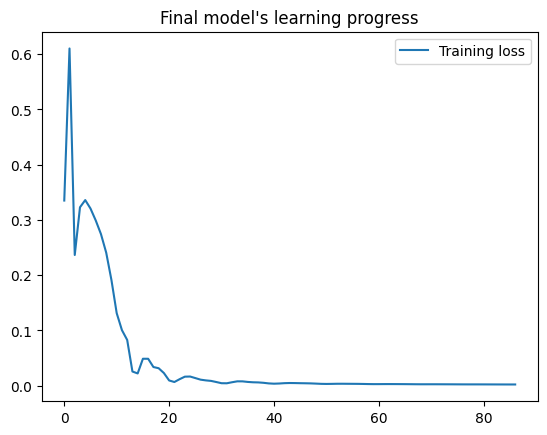

In [17]:
plt.plot(range(epochs), losses, label="Training loss")
plt.title("Final model's learning progress")
plt.legend()
plt.show()

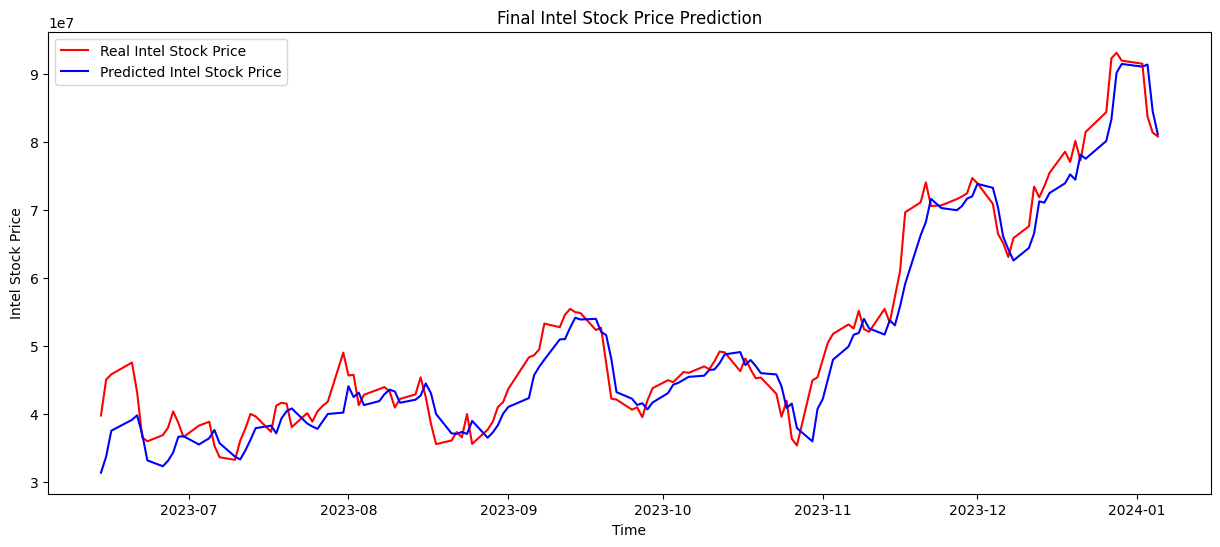

In [18]:
y_test_pred = model(x_test)
_y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
_y_test = scaler.inverse_transform(y_test.detach().numpy())

figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(stock_data[len(stock_data)-len(_y_test):].index, _y_test, color = 'red', label = 'Real Intel Stock Price')
axes.plot(stock_data[len(stock_data)-len(_y_test):].index, _y_test_pred, color = 'blue', label = 'Predicted Intel Stock Price')
plt.title('Final Intel Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Intel Stock Price')
plt.legend()
plt.show()